# <font style = "color:rgb(50,120,229)">SnapChat Filters : Aging</font>

# <font style = "color:rgb(50,120,229)">Introduction</font>

Back in 2012, three apps were released on the Apple App Store - Fatify, Baldify and Oldify. While the results looked decent and the apps were great for fun and giggles, I wondered who would buy the app. Turns out millions of people did and the apps made millions of dollars! 

In this lecture, we will learn how to apply an aging filter to a face. Based on what we have learned so far, you have all the knowledge needed to write an aging filter. 

> <font style="font-family:Poiret one" size = "+2">So, I want you to pause for 15 minutes and write down how you would go about building an aging filter.</font> 

## <font style = "color:rgb(50,120,229)">The Core Idea</font>

Before we design a filter, let’s first think of the various ways age affects the appearance of the face.

<center><a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-agingImage.png"><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-agingImage.png" width=500/></a></center>

1. **Wrinkles:** The most prominent change is perhaps the appearance of wrinkles on the face. 

2. **Spots:** It is very common for brown and black spots to show up on parts of the skin that is exposed to the sun. These spots are called Liver spots even though they have nothing to do with the Liver. 

3. **Paler appearance:** The skin actually appears pale and translucent. 

4. **Lower elasticity:** The skin loses elasticity and sags. 

If we think like a scientist, we will try to reproduce each of these effects on a facial photo. But this is a course for engineers. We will use shortcuts whenever we can! 

A frontal facial photograph of an old person, shown above, exhibits a lot of features related to aging. Can we borrow those features and apply it to our image? Yes, and that is the core idea. 

First, we will warp the wrinkle image to the coordinates of the input images and then perform seamless cloning with MIXED_CLONE option. 

We will go over the steps in the code section. However, there are a few things worth discussing before we dive into the code. 

### <font style = "color:rgb(50,120,229)">How to Estimate Forehead Points</font>

We know that Dlib’s landmark detector does not produce any points on the forehead. For aging application it is very important to have some points on the forehead because forehead wrinkles are important for showing aging. 

There are a few different ways of estimating forehead points. 

1. Train a new landmark detector with points on the forehead. 

2. Estimate the forehead points based on the current landmark points.

Of the two above two methods, the first one is no doubt more elegant, but it requires a large data collection effort. If you were building a commercial application, this may be the right path to take. 
<center><a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-landmarkPoints.png"><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-landmarkPoints.png" width=400/></a></center>
There are a few different ways of using option 2. One can train a linear regressor, that takes as input the current landmark points and outputs the forehead points. To train the linear regressor we need to manually mark forehead landmarks on a few hundred images. 

The final option is to come up with a heuristic that works fine for the application. We guesstimate four forehead points. See figure on the left. 

For each one of them we pick a point on the lower eyelid and another point on the eyebrow and extend the line by a fixed amount to land at our estimate of the forehead point. 





### <font style = "color:rgb(50,120,229)">How to Generate a Mask from Points</font>

Given a set of points on a polygon, we know we can create a mask using fillPoly or fillConvexPoly in OpenCV. 

Facial landmarks do not form a polygon. To find a face mask, we need to find a Convex Hull of all points. 

### <font style = "color:rgb(50,120,229)">What is a Convex hull?</font>
<center><a href="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-convexHull.png"><img src="https://www.learnopencv.com/wp-content/uploads/2018/01/opcv4face-w5-m5-convexHull.png" width=400/></a></center>

&nbsp;
The image on the left shows a few red points. The blue line is the Convex Hull. The convex hull of has two important properties

1. It is a **convex polygon.** This means that all internal angles are less than 180 degrees. The outer boundary has no concavities. 

2. It is a **hull**. The word hull is used in many contexts and almost everywhere it refers to the outer covering of something. In this case, the hull refers to the outer boundary of the points. All the points are either inside or on the hull. 

In OpenCV, you can use the function `convexHull` to find the convexHull.

In the code below, we use the convex hull to find a mask for the face to perform seamless cloning.

### <font style = "color:rgb(8,133,37)">Aging Filter Code and Tutorial</font>

Sometimes, it is easy to assume we know something but the devil is in the code! Let’s dive in and explore. 

In [1]:
#include "includeLibraries.h"

In [2]:
#include "matplotlibcpp.h"
#include "displayImages.h"

In [3]:
#include "faceBlendCommon.hpp"

In [4]:
using namespace cv;

In [5]:
using namespace std;

In [6]:
using namespace dlib;

In [7]:
#define FACE_DOWNSAMPLE_RATIO 1

First, let's write some functions for alpha blending, image desaturation, etc.

In [8]:
// Alpha blending using multiply and add functions
Mat& alphaBlend(Mat& alpha, Mat& foreground, Mat& background, Mat& outImage)
{
  Mat fore, back;
  multiply(alpha, foreground, fore, 1/255.0);
  multiply(Scalar::all(255)-alpha, background, back,1/255.0);
  add(fore, back, outImage);

  return outImage;
}

In [9]:
// Desaturate image
void desaturateImage(Mat &im, double scaleBy)
{
  // Convert input image to HSV
  Mat imgHSV;
  cv::cvtColor(im,imgHSV,COLOR_BGR2HSV);

  // Split HSV image into three channels.
  std::vector<Mat> channels(3);
  split(imgHSV,channels);

  // Multiple saturation by the scale.
  channels[1] = scaleBy * channels[1];

  // Merge back the three channels
  merge(channels,imgHSV);

  // Convert HSV to RGB
  cv::cvtColor(imgHSV,im,COLOR_HSV2BGR);

}

In [10]:
void removePolygonFromMask(Mat &mask, std::vector<Point2f> points, std::vector<int> pointsIndex)
{
  std::vector<Point> hullPoints;
  for(int i = 0; i < pointsIndex.size(); i++)
  {
    Point pt( points[pointsIndex[i]].x , points[pointsIndex[i]].y );
    hullPoints.push_back(pt);
  }
  fillConvexPoly(mask,&hullPoints[0], hullPoints.size(), Scalar(0,0,0));
}

In [11]:
void appendForeheadPoints(std::vector<Point2f> &points)
{

  double offsetScalp = 3.0;

  static int brows[] = {25, 23, 20, 18 };
  std::vector<int> browsIndex (brows, brows + sizeof(brows) / sizeof(brows[0]) );
  static int browsReference[] = {45, 47, 40, 36};
  std::vector<int> browsReferenceIndex (browsReference, browsReference + sizeof(browsReference) / sizeof(browsReference[0]) );

  for (unsigned long k = 0; k < browsIndex.size(); ++k)
  {
    Point2f foreheadPoint = offsetScalp * ( points[ browsIndex[k] ] - points[ browsReferenceIndex[k]]) + points[browsReferenceIndex[k]];
    points.push_back(foreheadPoint);
  }

}

In [12]:
Mat getFaceMask(Size size, std::vector<Point2f> points)
{

  // Left eye polygon
  static int leftEye[] = {36, 37, 38, 39, 40, 41};
  std::vector<int> leftEyeIndex (leftEye, leftEye + sizeof(leftEye) / sizeof(leftEye[0]) );

  // Right eye polygon
  static int rightEye[] = {42, 43, 44, 45, 46, 47};
  std::vector<int> rightEyeIndex (rightEye, rightEye + sizeof(rightEye) / sizeof(rightEye[0]) );

  // Mouth polygon
  static int mouth[] = {48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59};
  std::vector<int> mouthIndex (mouth, mouth + sizeof(mouth) / sizeof(mouth[0]) );

  // Nose polygon
  static int nose[] = {28, 31, 33, 35};
  std::vector<int> noseIndex (nose, nose + sizeof(nose) / sizeof(nose[0]) );

  // Find Convex hull of all points
  std::vector<Point2f> hull;
  convexHull(points, hull, false, true);

  // Convert to vector of Point2f to vector of Point
  std::vector<Point> hullInt;
  for(int i = 0; i < hull.size(); i++)
  {
    Point pt( hull[i].x , hull[i].y );
    hullInt.push_back(pt);
  }

  // Create mask such that convex hull is white.
  Mat mask = Mat::zeros(size.height, size.width, CV_8UC3);
  fillConvexPoly(mask,&hullInt[0], hullInt.size(), Scalar(255,255,255));

  // Remove eyes, mouth and nose from the mask.
  removePolygonFromMask(mask, points, leftEyeIndex);
  removePolygonFromMask(mask, points, rightEyeIndex);
  removePolygonFromMask(mask, points, noseIndex);
  removePolygonFromMask(mask, points, mouthIndex);

  return mask;

}

Load face detector and facial landmark detector

In [13]:
string modelPath = DATA_PATH + "models/shape_predictor_68_face_landmarks.dat";

In [14]:
// Load face detector
frontal_face_detector faceDetector = get_frontal_face_detector();

// Load landmark detector.
shape_predictor landmarkDetector;
deserialize(modelPath) >> landmarkDetector;

Read wrinkle image (`img1`) and input image (`img2`). The wrinkles will be applied to the input image.

In [15]:
// File to copy wrinkles from
string filename1 = DATA_PATH + "images/wrinkle2.jpg";

// File to apply aging
string filename2 = DATA_PATH + "images/ted_cruz.jpg";

In [16]:
// Read images
Mat img1 = imread(filename1);
Mat img2 = imread(filename2);

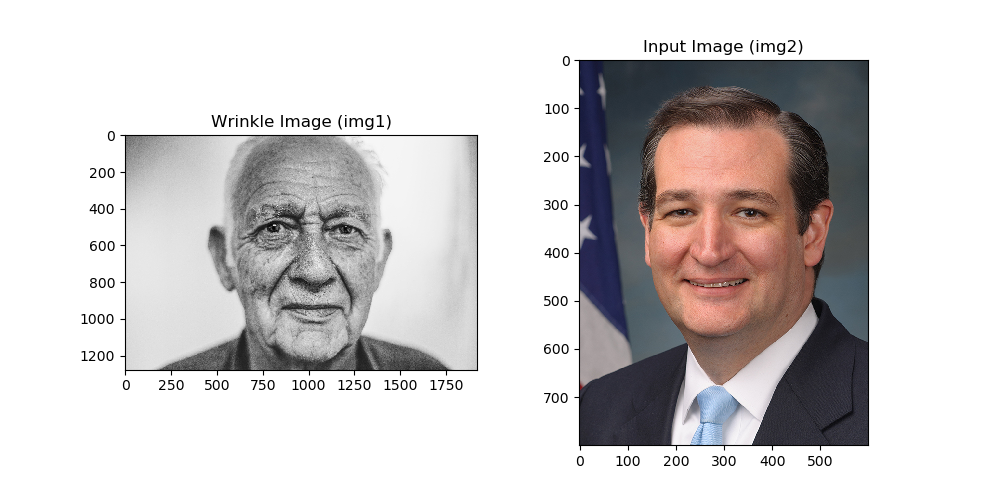

In [17]:
plt::figure_size(1000,500);
plt::subplot(1,2,1);
plt::imshow(img1);
plt::title("Wrinkle Image (img1)");
auto pltImg = displayImage(img1);
plt::subplot(1,2,2);
plt::imshow(img2);
plt::title("Input Image (img2)");
pltImg = displayImage(img2);
pltImg

Find landmarks and guesstimate forehead points 

In [18]:
// Read points corresponding to beard, stored in text files
std::vector<Point2f> getSavedPoints(string pointsFileName)
{
  std::vector<Point2f> points;
  ifstream ifs(pointsFileName.c_str());
  float x, y;
  if (!ifs)
    cout << "Unable to open file" << endl;
  while(ifs >> x >> y)
  {
    points.push_back(Point2f(x,y));
  }
  return points;
}

In [19]:
// Find landmarks.
std::vector<Point2f> points1, points2;

// points1 = getLandmarks(faceDetector, landmarkDetector, img1, (float)FACE_DOWNSAMPLE_RATIO);
// points2 = getLandmarks(faceDetector, landmarkDetector, img2, (float)FACE_DOWNSAMPLE_RATIO);
points1 = getSavedPoints(filename1 + ".txt");
points2 = getSavedPoints(filename2 + ".txt");

// Find forehead points.
appendForeheadPoints(points1);
appendForeheadPoints(points2);

In [20]:
// Find Delaunay Triangulation
std::vector< std::vector<int> > dt;
Rect rect(0, 0, img1.cols, img1.rows);
calculateDelaunayTriangles(rect, points1, dt);

Warp the wrinkle image to the input image one triangle at a time. 

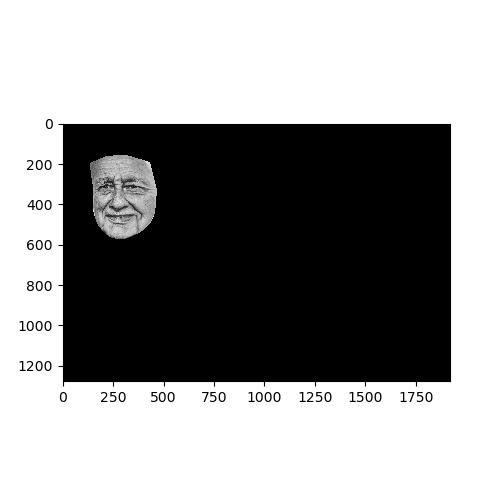

In [21]:
// Convert image for warping.
img1.convertTo(img1, CV_32F);
img2.convertTo(img2, CV_32F);

// Warp wrinkle image to face image.
Mat img1Warped = img2.clone();
warpImage(img1,img1Warped, points1, points2, dt);
img1Warped.convertTo(img1Warped, CV_8UC3);
img2.convertTo(img2, CV_8UC3);

plt::figure_size(500,500);
plt::imshow(img1Warped);
pltImg = displayImage(img1Warped);
pltImg

We do not want parts of the input image to be affected by the wrinkle image. So we create a mask where the eyes, mouth and nose regions are masked out.

The variable `clonedOutput` stores the results after seamless cloning. Noted we are using the `MIXED_CLONE` option because we just want the high gradient regions (wrinkles / spots etc.) from the wrinkle image.

In [22]:
// Calculate face mask for seamless cloning.
Mat mask = getFaceMask(img2.size(), points2);

// Seamlessly clone the wrinkle image onto original face
Rect r1 = boundingRect(points2);
Point center1 = (r1.tl() + r1.br()) / 2;
Mat clonedOutput;
seamlessClone(img1Warped,img2, mask, center1, clonedOutput, MIXED_CLONE);

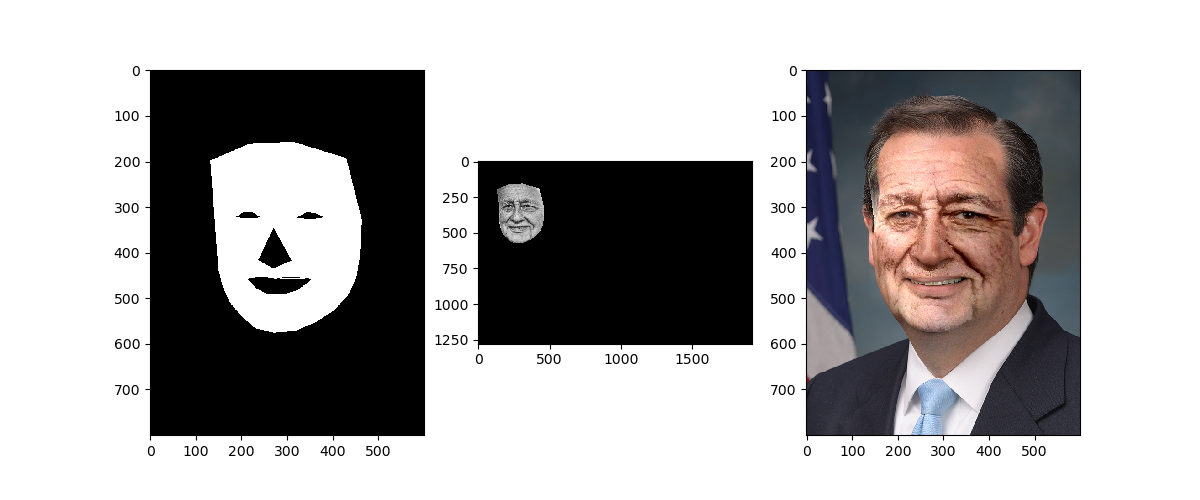

In [23]:
plt::figure_size(1200,500);
plt::subplot(1,3,1);
plt::imshow(mask);
pltImg = displayImage(mask);

plt::subplot(1,3,2);
plt::imshow(img1Warped);
pltImg = displayImage(img1Warped);

plt::subplot(1,3,3);
plt::imshow(clonedOutput);
pltImg = displayImage(clonedOutput);

pltImg

When with seamless cloning, it is a good idea to blur the mask and use it to alpha blend the original image. This is because the mask is made out of polygons with sharp edges and these edges may show up in the final image.

The mask can be of any size. To apply a consistent blur, we can resize the mask to a constant size, apply a constant size blur on it, and then resize it back to the original size. Admittedly, this is a hack. One can argue that the right way is to apply a large blur kernel to the high resolution image. But doing so can be computationally expensive. Hence, this computationally cheap hack.

Also, notice we erode the mask slightly before blurring it. This is because we want the alpha to be near zero near the boundary of the seamless cloned region because the boundary has a sharp edge.

In [24]:
// Blurring face mask to alpha blend to hide seams
Size size = mask.size();
Mat maskSmall;
resize(mask, maskSmall, Size(256, int((size.height) * 256.0/double(size.width))));
erode(maskSmall, maskSmall, Mat(), Point(-1,-1), 5);
GaussianBlur(maskSmall, maskSmall, Size(15,15), 0, 0);
resize(maskSmall, mask, size);

Once the mask is blurred, we alpha blend the original image and the cloned image.



In [25]:
Mat agedImage = clonedOutput.clone();
alphaBlend(mask, clonedOutput, img2, agedImage);

The blurred mask, cloned image and the alpha blended images are shown below. Note the sharp edge visible on the forehead in `clonedOutput` is much better blended in `agedImage`

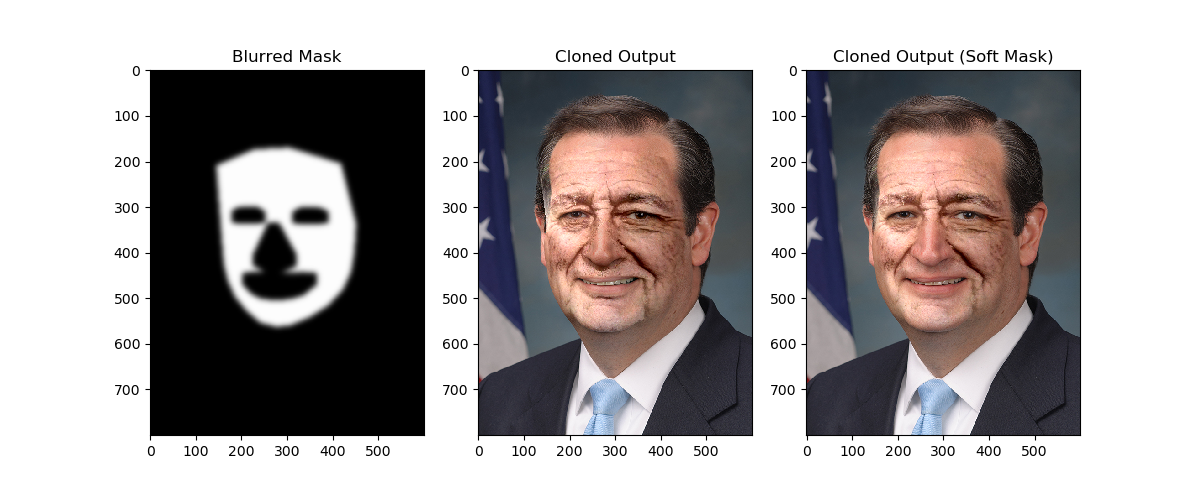

In [26]:
plt::figure_size(1200,500);
plt::subplot(1,3,1);
plt::imshow(mask);
plt::title("Blurred Mask");
pltImg = displayImage(mask);

plt::subplot(1,3,2);
plt::imshow(clonedOutput);
plt::title("Cloned Output");
pltImg = displayImage(clonedOutput);

plt::subplot(1,3,3);
plt::imshow(agedImage);
plt::title("Cloned Output (Soft Mask)");
pltImg = displayImage(agedImage);

pltImg

Finally, we desaturate the final image. It has two effects. First, aging leads to a paler skin and desaturation simulates that effect. Second, the entire photo looks discolored and old. The overall effect is that we make the person look old and from an old time.

In [27]:
// Desaturate output
desaturateImage(agedImage, 0.8);

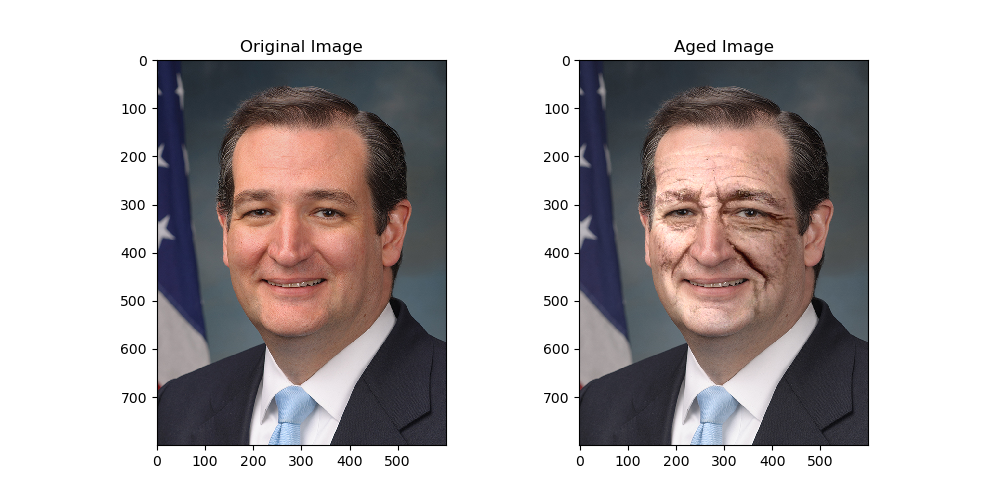

In [28]:
plt::figure_size(1000,500);
plt::subplot(1,2,1);
plt::imshow(img2);
plt::title("Original Image");
pltImg = displayImage(img2);

plt::subplot(1,2,2);
plt::imshow(agedImage);
plt::title("Aged Image");
pltImg = displayImage(agedImage);
pltImg